### Preamble

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt

from typing import *
from tqdm.notebook import tqdm
from matplotlib.colors import Normalize
from sobol_seq import i4_sobol_generate
from gpflow.config import default_float
from tensorflow_probability.python import bijectors as tfb

from utils.plotting import *
from gpflow_sampling.samplers import decoupled
from dynamical_systems import ModelBasedSystem, FitzHughNagumo

In [2]:
%matplotlib inline
set_default_rcParams(plt, fontsize=14, usetex=True)

In [3]:
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Problem setup

In [4]:
class Flags(NamedTuple):
    dtype: Any = default_float()
    state_dim: int = 2
    control_dim: int = 1

    horizon: float = 250
    step_size: float = 0.25
    noise_var: float = 1e-2

    num_train: int = 10000
    batch_size: int = 256
    num_batches: int = 5000
    num_inducing: int = 256
    num_paths: int = 1024
    
    @property
    def input_dim(self):  # dimensionality of model inputs
        return self.state_dim + self.control_dim
    
    @property
    def target_dim(self):  # dimensionality of model outputs
        return self.state_dim
    
flags = Flags()

In [5]:
def noise_func(x, t, dt):  # diffusion
    stddev = tf.cast(0.01 * tf.math.rsqrt(dt), x.dtype)
    return tf.random.normal(x.shape, stddev=stddev, dtype=x.dtype)

neuron = FitzHughNagumo(noise_func=noise_func)

### Initialize sparse GP

In [6]:
def create_model(flags):
    kernels = []
    inducing_points = []
    for d in range(flags.target_dim):
        mesh = i4_sobol_generate(flags.input_dim, flags.num_inducing)
        Z = tf.Variable(mesh.astype(default_float()),
                        constraint=lambda x: tf.clip_by_value(x, 0, 1))

        inducing_points.append(gpflow.inducing_variables.InducingPoints(Z))
        kernels.append(gpflow.kernels.Matern52(lengthscales=Z.shape[-1] * [1.0]))
        
    def mean_function(X):
        return 0.0  # enables us to broadcast

    kernel = gpflow.kernels.SeparateIndependent(kernels=kernels)
    likelihood = gpflow.likelihoods.Gaussian(variance=tf.Variable(1e-5, dtype=flags.dtype))
    inducing_vars = gpflow.inducing_variables.SeparateIndependentInducingVariables(inducing_points)
    return gpflow.models.SVGP(kernel=kernel,
                              likelihood=likelihood,
                              mean_function=mean_function,
                              inducing_variable=inducing_vars,
                              num_data=flags.num_train,
                              num_latent_gps=flags.target_dim)

model = create_model(flags)

### Train the sparse GP

In [7]:
train_x = tf.random.uniform(shape=[flags.num_train, flags.state_dim], dtype=flags.dtype)
train_u = tf.random.uniform(shape=[flags.num_train, flags.control_dim], dtype=flags.dtype)
train_y = neuron.forward(x=train_x, u=train_u, t=None, dt=flags.step_size)

def batch_provider(batch_size, x=train_x, u=train_u, y=train_y):
    if batch_size < flags.num_train:
        indices = np.random.choice(flags.num_train, batch_size, replace=False)
        x = tf.gather(x, indices, axis=0)
        u = tf.gather(u, indices, axis=0)
        y = tf.gather(y, indices, axis=0)
    return tf.concat([x, u], axis=-1), y

boundaries = [int(0.5 * flags.num_batches), int(0.75 * flags.num_batches)]
schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, [1e-2, 1e-3, 1e-4])
optimizer = tf.optimizers.Adam(schedule)
for step in tqdm(range(flags.num_batches)):
    batch = batch_provider(flags.batch_size)
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        obj = model.training_loss(batch)
    grads = tape.gradient(obj, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

### Generate sample paths

In [8]:
paths = decoupled(model, model.kernel, sample_shape=[flags.num_paths], num_basis=1024)

@tf.function
def paths_wrapper(inputs, t=None, dt=None, **kwargs):
    return paths(inputs, **kwargs)

def noise_func(x, t, dt, **kwargs):
    stddev = tf.sqrt(model.likelihood.variance/dt)
    return tf.random.normal(x.shape, stddev=stddev, dtype=x.dtype)

surrogate = ModelBasedSystem(model=paths_wrapper,
                             noise_func=noise_func,
                             bijector=neuron.bijector,
                             controllable=True)

### Visualize vector fields

In [9]:
mesh = np.meshgrid(*(2*[np.linspace(0, 1, 100)]))
grid = np.stack([arr.flat for arr in mesh], axis=-1)
ctrl = tf.fill(list(grid.shape[:-1]) + [1], tf.cast(0.5, dtype=flags.dtype))
inputs = tf.concat([grid, ctrl], axis=-1)  # model inputs
fields = {'Ground truth': neuron.forward(x=grid, t=None, dt=None, noisy=False, u=ctrl),
          'Surrogate (mean)': model.predict_f(inputs)[0]}

In [10]:
# Generate a standalone sample path for us to visualize
path = decoupled(model, model.kernel, sample_shape=[1], num_basis=1024)
fields['Surrogate (sample)'] = paths(inputs)[0]

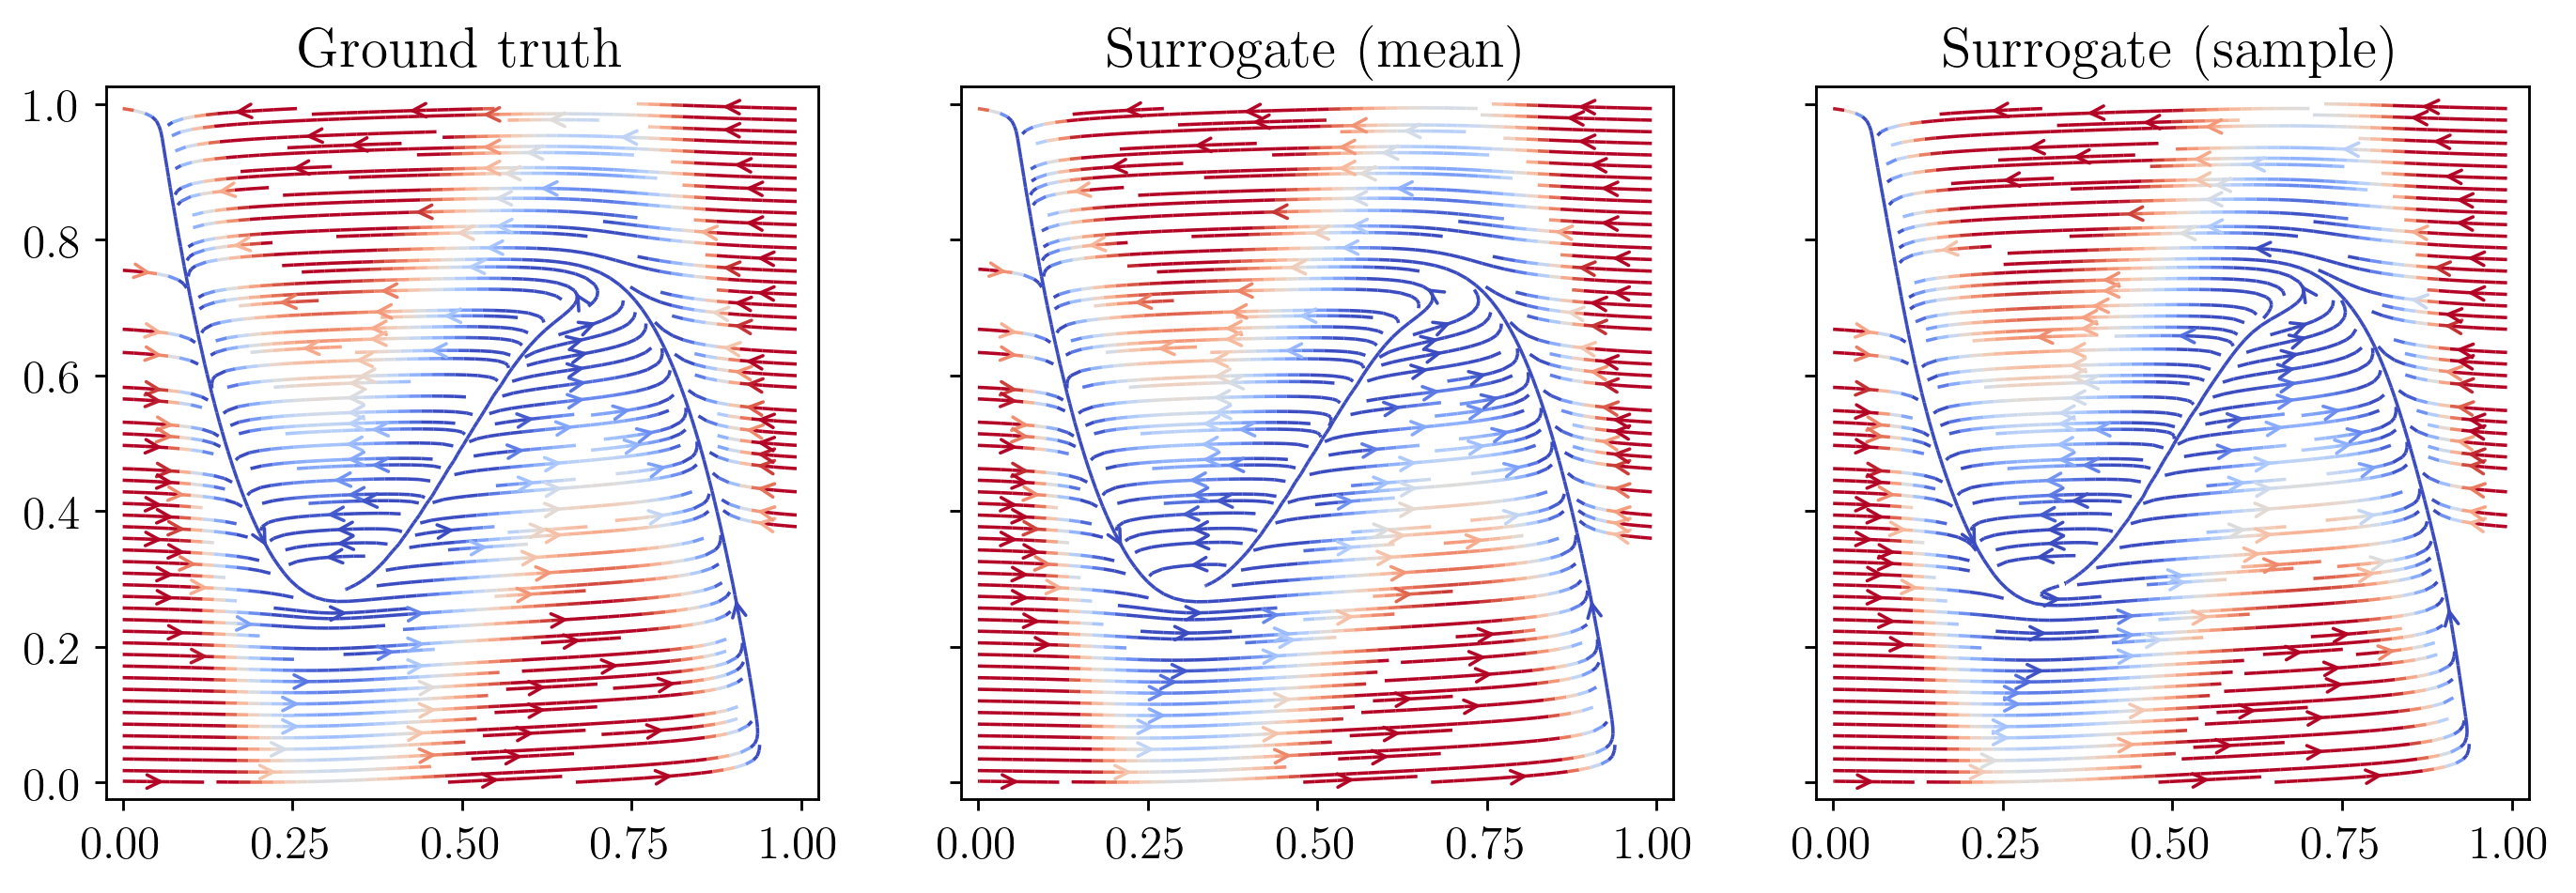

In [11]:
fig, axes = plt.subplots(figsize=(13, 4), nrows=1, ncols=3, sharex='all', sharey='all')
vmin, vmax = np.inf, -np.inf
for field in fields.values():
    vals = tf.norm(field, axis=-1)
    vmin = min(vmin, tf.reduce_min(vals))
    vmax = max(vmax, tf.reduce_max(vals))

color_norm = Normalize(vmin, vmax)
for k, (ax, (title, field)) in enumerate(zip(np.ravel(axes), fields.items())):
    ax.set_title(title)
    _shape = tuple(field.shape[:-2]) + mesh[0].shape + (-1,)
    _field = neuron.bijector(tf.reshape(field, _shape))
    ax.streamplot(*mesh,
                  *tf.unstack(_field, 2, axis=-1),
                  color=tf.norm(_field, axis=-1).numpy(),
                  density=2,
                  linewidth=1,
                  arrowstyle='->',
                  arrowsize=1.0,
                  cmap='coolwarm', 
                  norm=color_norm)

for ax in axes:
    ax.set_xlim(-0.025, 1.025)
    ax.set_ylim(-0.025, 1.025)
    ax.set_aspect('equal')

### Simulate time evolution

In [12]:
time_steps = np.arange(0, flags.horizon, flags.step_size)
def control_func(t, *args, **kwargs):
    u = tf.cast(0.25 * (1.0 - tf.cos(1.0 + t/30)), dtype=flags.dtype)
    return u if (len(u.shape) >= 1) else tf.expand_dims(u, axis=0)

# Unroll to find steady state
x0 = neuron.unroll(tf.zeros([1, flags.state_dim], dtype=flags.dtype),
                         time_steps=time_steps,
                         noisy=False)[-1]


# Unroll trajectories for different control input sequences
_x0 = tf.tile(x0[None], [flags.num_paths, 1, 1])
results = AttrDict()
results.neuron = tf.squeeze(neuron.unroll(_x0,
                                          control_func=control_func,
                                          time_steps=time_steps,
                                          noisy=True))

results.model = tf.squeeze(surrogate.unroll(_x0,
                                            control_func=control_func, 
                                            time_steps=time_steps,
                                            noisy=True))

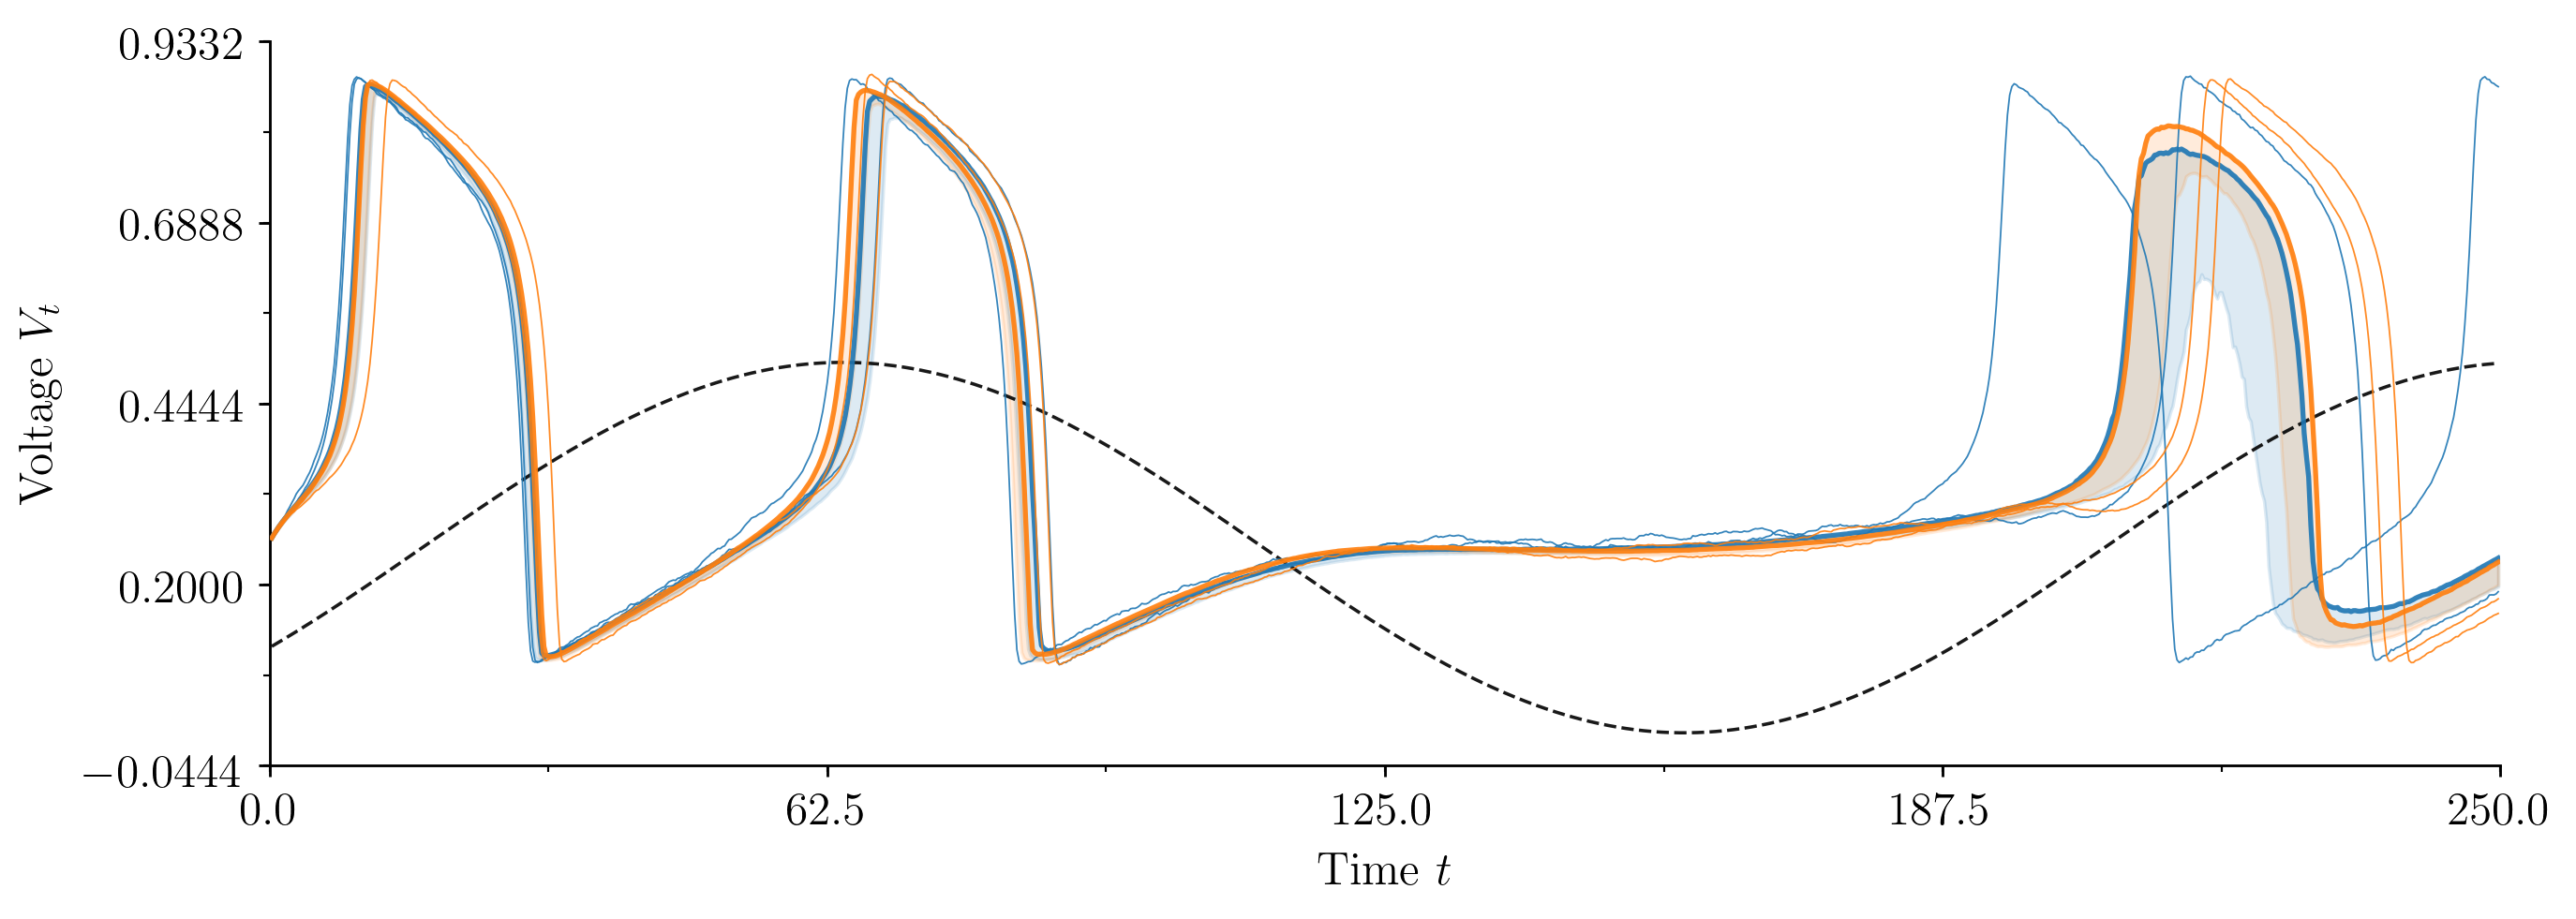

In [13]:
style = AttrDict()
style.control_func = ObjectStyle(color='k', linestyle='--', linewidth=1.0)
style.neuron = ObjectStyle(color='tab:blue')
style.model = ObjectStyle(color='tab:orange')

fig, ax = plt.subplots(figsize=(12, 4))
with set_temporary_ax(ax):
    plot_line(time_steps[1:], control_func(time_steps[1:]), **style.control_func)
    
    quartiles = np.quantile(results.neuron[..., 0], [0.25, 0.5, 0.75], axis=1)
    plot_line(time_steps[1:], quartiles[1], **style.neuron)
    plot_fill(time_steps[1:], quartiles[0], quartiles[1], **style.neuron)
    for seq in tf.unstack(results.neuron, axis=1)[:2]:
        plot_line(time_steps[1:], seq[..., 0],  linewidth=0.5, **style.neuron)
    
    quartiles = np.quantile(results.model[..., 0], [0.25, 0.5, 0.75], axis=1)
    plot_line(time_steps[1:], quartiles[1], **style.model)
    plot_fill(time_steps[1:], quartiles[0], quartiles[1], **style.model)

    for seq in tf.unstack(results.model, axis=1)[:2]:
        plot_line(time_steps[1:], seq[..., 0], linewidth=0.5, **style.model)
    
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Voltage $V_{t}$')
    format_axes(xlim=(0, flags.horizon), num_major=5, num_minor=9, despine=True)